In [4]:
import matplotlib
%matplotlib inline
matplotlib.rcParams['font.size'] =28.0
import matplotlib.pyplot as plt
import numpy as np
import loadMWSnap as mws
import velocitySpectroscopyHelpers as vsh
import healpy as hp
reload(mws);
reload(vsh);

In [2]:
reload(mws);
# Load the particle data
# pos in physical kpc, vel in km/s, mass in physical m_sun
rawpos, rawvel, partmass, ldim, data = mws.loadMWSnap(halo=374)
pos = rawpos - vsh.pos_sun
vel = rawvel - vsh.vel_sun

Reading rockstar output /nfs/slac/g/ki/ki21/cosmo/yymao/mw_resims/halos/Halo374/rockstar/hlists/hlist_1.00000.list
Reading MUSIC log /nfs/slac/g/ki/ki21/cosmo/yymao/mw_resims/halos/Halo374/music.conf_log.txt
Lagrangian patch dimensions are (486, 224, 242)
Reading Gadget snapshot /nfs/slac/g/ki/ki21/cosmo/yymao/mw_resims/halos/Halo374/output/snapshot_235


/lustre/ki/pfs/dmpowel1/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10


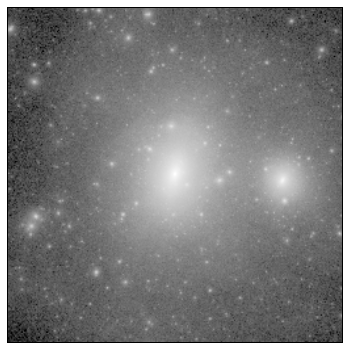

In [69]:
# Figure of Halo 374
fsz = 6
fig, ax = plt.subplots(1, 1, figsize=(fsz, fsz))

ran = 275.7

fpos=rawpos
# fpos = pos[np.sum(pos**2, axis=1)<ran**2]

hist, xe, ye = np.histogram2d(fpos[:,0], fpos[:,1], bins=256, range=[[-ran, ran], [-ran, ran]])
imargs = {'cmap': plt.cm.Greys_r, 'origin': 'lower', 'extent': [-ran, ran, -ran, ran]}
ax.imshow(np.log10(hist), **imargs)
# ax.imshow(hist, **imargs)

# ax.axis('off')
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
ax.set_axis_bgcolor('black')

fig.savefig('../img/halo374.png', bbox_inches='tight')

-0.25923677767 0.409085487658
0.576133638681 0.398524588669


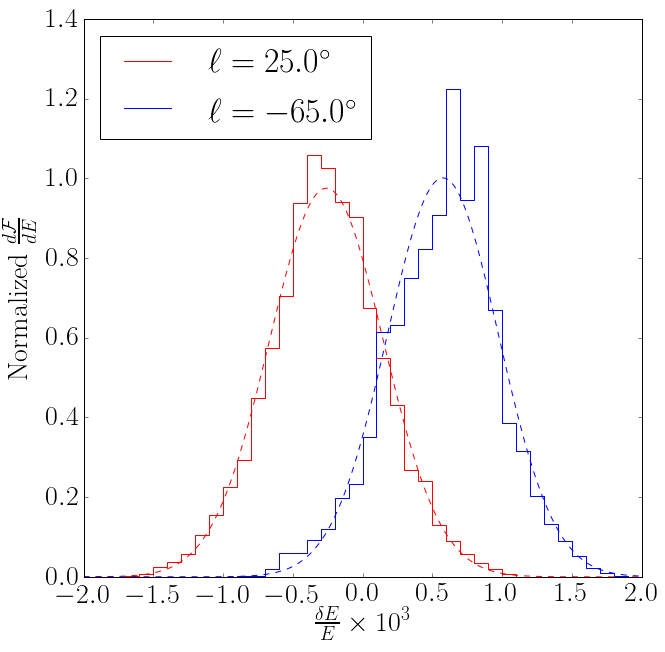

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

def gauss(x, sigma, mu):
    return (2*np.pi*sigma**2)**-0.5 * np.exp(-(x-mu)**2/(2*sigma**2))
#     return np.exp((x-mu)**2/(2*sigma**2))
ran=2.0
xp = np.linspace(-ran,ran,200)
colors=['red', 'blue']
for i, lon in enumerate([25.0, -65.0]):
    _, v_los, r_los = vsh.sample_los(pos, vel/3.0e5*10**3, lon=lon, lat=25.0, beam_radius=20.0)

    # histogram the bins
    hist, bins = np.histogram(v_los, bins=40, range=(-ran, ran), weights=r_los**-2, density=True)
    bins = 0.5*(bins[1:]+bins[:-1]) # rescale bins to be in terms of fractional energy shift

    # Gaussian model parameters
    center = np.average(v_los, weights=r_los**-2)
    sigma = np.average((v_los-center)**2, weights=r_los**-2)**0.5
    print center, sigma

    ax.plot(bins, hist, '-', drawstyle='steps-mid', label=r'$\ell=%.1f^\circ$'%lon, c=colors[i])
    ax.plot(xp, gauss(xp, sigma, center), '--', c=colors[i])
    
# ax.set_title(r'Observed spectrum')
ax.set_xlabel(r'$\frac{\delta E}{E} \times 10^3$')
ax.set_ylabel(r'Normalized $\frac{d\mathcal{F}}{dE}$')
ax.legend(loc='upper left')

fig.savefig('../img/dnde_demo.png', bbox_inches='tight')

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


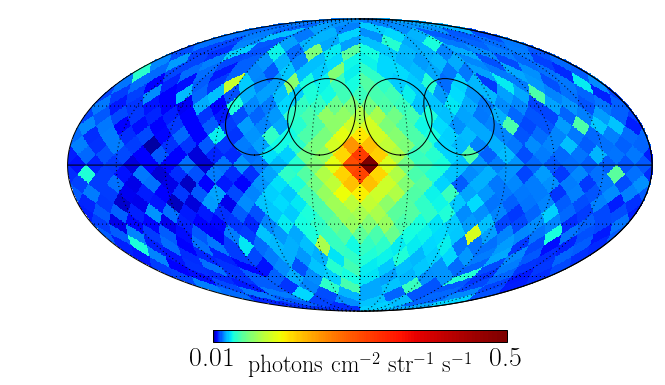

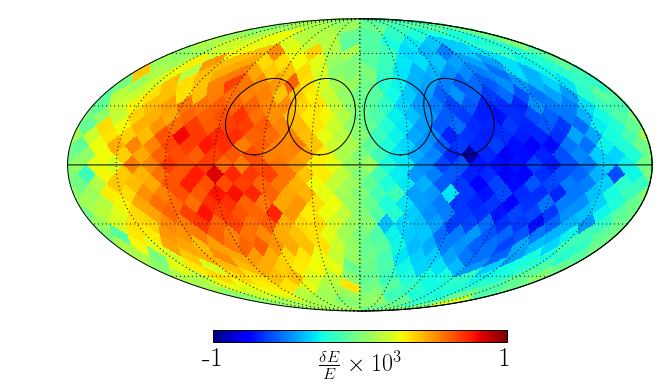

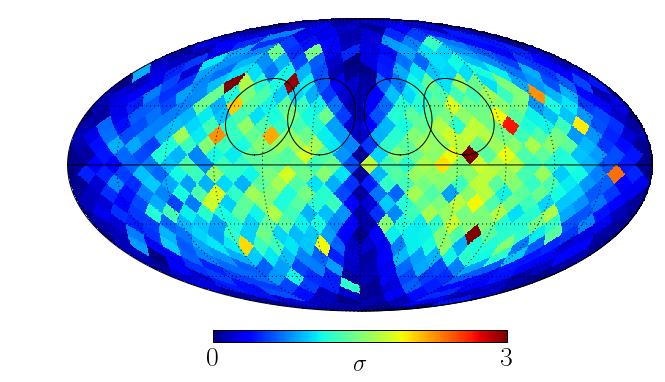

In [22]:
reload(vsh);  
hpspec = vsh.spectroscopy_healpix(pos, vel, partmass, nside=8)
def plot_beams(lon=[-85., -65., -45., -25., 0.0, 25., 45., 65., 85.], lat=25.0, beamrad=20.0):
    beamargs = {'rot': (180,0,0), 'lonlat': True, 'c': 'black'} 
    bphi = np.linspace(0., 360., 50)
    bthe = (90.0-beamrad)*np.ones_like(bphi)
    for l in lon:
        beamargs['rot'] = (180.0-l, lat, 0.0)
#         hp.projscatter(0, 90.0, **beamargs)
        hp.projplot(bphi, bthe, **beamargs)
    
def bigger_units():
    f = plt.gcf().get_children()
    CbAx = f[2]

    unit_text_obj = CbAx.get_children()[1]
    unit_text_obj.set_fontsize(24.0)
    unit_text_obj.set_va('top')
#     unit_text_obj.set_y(1.0)

# make Moll
mapargs = {'rot': (180,0,0), 'margins': (0,0,0,0)} 

# matplotlib.rcParams['axes.labelsize'] =28.0

# properly scale flux for astro-h to get number counts
ahs = 1.0*0.37892243899248773*300.0

hp.mollview(hpspec['flux'], norm='log', title='', min = .01, max=0.5, \
            unit=r'$\mathrm{photons~cm^{-2}~str^{-1}~s^{-1}}$', **mapargs);
# plot_beams()
plot_beams(lon=[-65., -25., 25., 65.])
hp.graticule();
bigger_units()
plt.savefig('../img/flux_map_374.png', bbox_inches='tight', pad_inches=0)

hp.mollview(hpspec['centroid']*10**3, min=-1.0, max=1.0, title='', \
            unit=r'$\frac{\delta E}{E} \times 10^3$', **mapargs);
plot_beams(lon=[-65., -25., 25., 65.])
hp.graticule();
bigger_units();
plt.savefig('../img/line_map_374.png', bbox_inches='tight', pad_inches=0)

# hp.mollview(hpspec['sigma_centroid']*10**3, title='Centroid uncertainty', \
#             unit=r'$\frac{\delta E}{E} \times 10^3$', **mapargs)
# hp.graticule();

hp.mollview(np.abs(hpspec['centroid']/hpspec['sigma_centroid'])*ahs**0.5, min = 0, max=3, \
            title='', unit=r'$\sigma$', **mapargs);
plot_beams(lon=[-65., -25., 25., 65.])
hp.graticule();
bigger_units();
plt.savefig('../img/sigma_map_374.png', bbox_inches='tight', pad_inches=0)


In [12]:
'''
An example plot to show how sampling is done

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
zoom = 800 # kpc
ax.set_xlim([-0.5*zoom, 0.5*zoom])
ax.set_ylim([-0.5*zoom, 0.5*zoom])
ax.set_title(r'MW halo: Sampling the FOV')
ax.set_xlabel(r'$x$ [kpc]')
ax.set_ylabel(r'$y$ [kpc]')
cpos, _, _ = vsh.sample_los(pos, vel, beam_radius=20.0)
sfilt = np.abs(pos[:,2]) < 1.0 # filter all particles into a thin 1 kpc slab to make plotting easier
ax.scatter(pos[sfilt][:,0], pos[sfilt][:,1], s=0.5, c='black', lw=0)
ax.scatter(cpos[:,0], cpos[:,1], s=2.0, c='red', lw=0)
'''

"\n# an example plot to show how sampling is done\n\nfig, ax = plt.subplots(1, 1, figsize=(10, 10))\nzoom = 800 # kpc\nax.set_xlim([-0.5*zoom, 0.5*zoom])\nax.set_ylim([-0.5*zoom, 0.5*zoom])\nax.set_title(r'MW halo: Sampling the FOV')\nax.set_xlabel(r'$x$ [kpc]')\nax.set_ylabel(r'$y$ [kpc]')\ncpos, _, _ = vsh.sample_los(pos, vel, beam_radius=20.0)\nsfilt = np.abs(pos[:,2]) < 1.0 # filter all particles into a thin 1 kpc slab to make plotting easier\nax.scatter(pos[sfilt][:,0], pos[sfilt][:,1], s=0.5, c='black', lw=0)\nax.scatter(cpos[:,0], cpos[:,1], s=2.0, c='red', lw=0)\n"

In [ ]:
'''
Code to test uniformity of 3d rotation sampling.
Looks good!

from mpl_toolkits.mplot3d import Axes3D
fig = matplotlib.pyplot.figure(figsize=(10,10))
ax  = fig.add_subplot(111, projection = '3d')

whisk = np.array([[-0.02, 0.0, 1.0], [0.02, 0.0, 1.0]])

for i in xrange(5000):
    rot = vsh.generateRotationMatrix()
    w = np.dot(whisk, rot)
    ax.plot(w[:,0], w[:,1], w[:,2], color = 'b');

ax.set_xlim([-1.1, 1.1]);
ax.set_ylim([-1.1, 1.1]);
ax.set_zlim([-1.1, 1.1]);
'''